### Lens modeling with `lenstronomy`
**Authors:** Mir Sazzat Hossain

#### Importing the required packages

In [1]:
import h5py
import joblib
import matplotlib.pyplot as plt
import numpy as np
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Util import mask_util, util
from lenstronomy.Workflow.fitting_sequence import FittingSequence


#### Read the data file

In [2]:
with h5py.File('DESIJ1205+4110_F140W.h5', 'r') as f:
    kwargs_data = {}

    for key in f:
        if key == 'exposure_time':
            kwargs_data[key] = f[key][()]
            continue
        kwargs_data[key] = f[key][()]

# print kwargs_data
for key in kwargs_data:
    print(f'{key}: {kwargs_data[key]}')


background_rms: 0.013529882338632617
dec_at_xy_0: -6.439999999999993
exposure_time: [[491.83884 476.48804 474.46265 ... 411.18542 444.9668  421.98083]
 [303.8621  494.6744  411.66196 ... 418.6309  562.59924 489.38327]
 [403.26965 442.603   419.66995 ... 439.60925 471.8495  454.18597]
 ...
 [375.34952 515.64874 387.16785 ... 479.0426  523.1591  434.5421 ]
 [413.6967  514.0231  469.48065 ... 402.32758 455.61356 456.5683 ]
 [446.8492  500.807   443.8337  ... 459.1944  448.02713 504.2699 ]]
image_data: [[ 0.01782471  0.00153406 -0.00369    ...  0.02928915  0.00779493
   0.01772262]
 [-0.00493755 -0.0280599  -0.01998502 ...  0.01026938 -0.01949841
   0.01028264]
 [-0.02581293 -0.02527415 -0.01339567 ...  0.03498907  0.02121747
  -0.0160352 ]
 ...
 [-0.00601441  0.00527194 -0.01063343 ... -0.01345688 -0.02050141
  -0.01655289]
 [-0.01265608 -0.00728262 -0.01940736 ... -0.02274422 -0.02119467
   0.00721132]
 [-0.01204946 -0.02231948 -0.01162757 ...  0.00166896  0.00150102
   0.00346738]]
ra_a

#### Load PSF data


In [3]:
with h5py.File('psf_F140W.h5', 'r') as f:
    kwargs_psf = {}

    for key in f:
        kwargs_psf[key] = f[key][()]

kwargs_psf['psf_type'] = 'PIXEL'
print(kwargs_psf)


{'kernel_point_source': array([[5.7422681e-06, 4.5087054e-06, 2.4900439e-06, ..., 1.8486933e-06,
        3.2385867e-06, 4.4331632e-06],
       [3.9503216e-06, 9.9817180e-06, 6.5966469e-06, ..., 3.9997908e-06,
        6.6143798e-06, 4.1430776e-06],
       [2.9697005e-06, 5.5563592e-06, 1.2795975e-05, ..., 7.8115263e-06,
        5.1404800e-06, 1.7530243e-06],
       ...,
       [1.6921831e-06, 3.7347368e-06, 7.6415899e-06, ..., 1.1465157e-05,
        5.3933368e-06, 1.6360833e-06],
       [2.8819463e-06, 6.2348781e-06, 4.7564718e-06, ..., 4.5906190e-06,
        8.7221979e-06, 3.7005334e-06],
       [3.7170516e-06, 3.6243027e-06, 1.6518559e-06, ..., 2.0127884e-06,
        3.2246478e-06, 5.1252514e-06]], dtype=float32), 'psf_type': 'PIXEL'}


#### Get the image data from `kwargs_data` and plot it

/tmp/ipykernel_11429/1291058028.py:3: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(image_data), origin='lower', cmap='cubehelix')


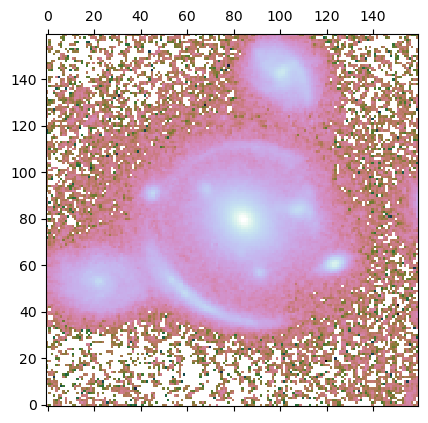

In [4]:
image_data = kwargs_data['image_data']

plt.matshow(np.log10(image_data), origin='lower', cmap='cubehelix')
plt.show()


#### Make mask and plot it

/tmp/ipykernel_11429/752698499.py:56: RuntimeWarning: invalid value encountered in log10
  ax1.matshow(np.log10(image_data), origin='lower', cmap='cubehelix')
/tmp/ipykernel_11429/752698499.py:67: RuntimeWarning: divide by zero encountered in log10
  ax3.matshow(np.log10(masked_image_data), origin='lower', cmap='cubehelix')
/tmp/ipykernel_11429/752698499.py:67: RuntimeWarning: invalid value encountered in log10
  ax3.matshow(np.log10(masked_image_data), origin='lower', cmap='cubehelix')


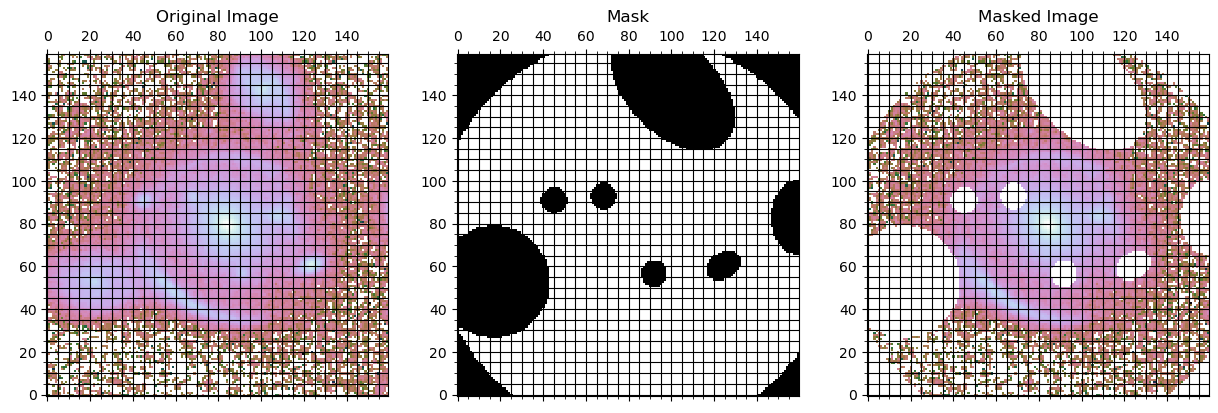

In [5]:
ra_at_xy_0 = kwargs_data['ra_at_xy_0']
dec_at_xy_0 = kwargs_data['dec_at_xy_0']
transform_pix2angle = kwargs_data['transform_pix2angle']

coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data['image_data'])

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)

r = 7.5  # arcseconds
lens_center_ra = 0
lens_center_dec = 0

mask_outer = mask_util.mask_center_2d(
    lens_center_ra - 0.2,
    lens_center_dec - 0.5,
    r,
    util.image2array(x_coords),
    util.image2array(y_coords)
)

mask_params = [
    [-3.5, -1.6, 0.7, 0.5, -np.pi/180 *30], # x, y, q, phi, theta
    [2.84, 0.85, 0.5, 0.5, 0],
    [1., 1., 0.5, 0.5, 0],
    [-0.9, -1.9, 0.5, 0.5, 0],
    # [-2.2, 0.28, 0.5, 0.5, 0],
    [5.1, -2.2, 2.1, 2.1, np.pi/5],
    [-1.6, 5, 2.8, 1.7, np.pi/4],
    [-6.28, 0.2, 1.4, 1, np.pi/2],
]

mask = 1 - mask_outer

for mask_param in mask_params:
    mask *= 1 -  mask_util.mask_ellipse(
                    util.image2array(x_coords),
                    util.image2array(y_coords),
                    mask_param[0],
                    mask_param[1],
                    mask_param[2],
                    mask_param[3],
                    mask_param[4]
                )

mask[mask >= 1] = 1
mask[mask < 0] = 0

mask = mask.reshape(num_pix, num_pix)

# mask image data
masked_image_data = np.multiply(image_data, mask)

# plot image and masked image
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.matshow(np.log10(image_data), origin='lower', cmap='cubehelix')
ax1.grid(which='both', color='black')
ax1.minorticks_on()
ax1.grid(which='minor', color='black')
ax1.title.set_text('Original Image')
ax2.matshow(mask, origin='lower', cmap='cubehelix')
ax2.grid(which='both', color='black')
ax2.minorticks_on()
ax2.grid(which='minor', color='black')
ax2.title.set_text('Mask')
ax2.title.set_text('Mask')
ax3.matshow(np.log10(masked_image_data), origin='lower', cmap='cubehelix')
ax3.grid(which='both', color='black')
ax3.minorticks_on()
ax3.grid(which='minor', color='black')
ax3.title.set_text('Masked Image')
plt.show()


### Building a lens model

In [6]:
lens_model_list = ['EPL', 'SHEAR']
source_model_list = ['SERSIC_ELLIPSE', 'SHAPELETS']
lens_light_model_list = ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'SERSIC_ELLIPSE']


#### Lens galaxy's mass model

In [7]:
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

# lens galaxy's elliptical power-law profile
fixed_lens.append({})

kwargs_lens_init.append({
    'theta_E': 2.88,
    'gamma': 2.,
    'e1': 0.1,
    'e2': 0.1,
    'center_x': -0.75,
    'center_y': 0.05,
})

kwargs_lens_sigma.append({
    'theta_E': 0.2,
    'gamma': 0.1,
    'e1': 0.05,
    'e2': 0.05,
    'center_x': 0.5,
    'center_y': 0.5
})

kwargs_lower_lens.append({
    'theta_E': 0.01,
    'gamma': 1.,
    'e1': -0.5,
    'e2': -0.5,
    'center_x': -3,
    'center_y': -3
})

kwargs_upper_lens.append({
    'theta_E': 10.,
    'gamma': 3.,
    'e1': 0.5,
    'e2': 0.5,
    'center_x': 3,
    'center_y': 3
})

# lens galaxy's external shear profile
fixed_lens.append({
    'ra_0': 0.,
    'dec_0': 0.
})

kwargs_lens_init.append({
    'gamma1': -0.02,
    'gamma2': 0.1
})

kwargs_lens_sigma.append({
    'gamma1': 0.05,
    'gamma2': 0.05
})

kwargs_lower_lens.append({
    'gamma1': -0.4,
    'gamma2': -0.4
})

kwargs_upper_lens.append({
    'gamma1': 0.4,
    'gamma2': 0.4
})

lens_params = [
    kwargs_lens_init,
    kwargs_lens_sigma,
    fixed_lens,
    kwargs_lower_lens,
    kwargs_upper_lens
]


#### Lens galaxy's light model

In [8]:
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

# lens galaxy's elliptical Sersic profile (first one)
fixed_lens_light.append({'n_sersic': 1.})

kwargs_lens_light_init.append({
    'R_sersic': 0.17,
    'n_sersic': 1.,
    'e1': -0.15,
    'e2': 0.2,
    'center_x': -0.3,
    'center_y': -0.06,
    'amp': 1
})

kwargs_lens_light_sigma.append({
    'R_sersic': 0.3,
    'n_sersic': 1,
    'e1': 0.05,
    'e2': 0.05,
    'center_x': 0.1,
    'center_y': 0.1,
    'amp': 10
})

kwargs_lower_lens_light.append({
    'R_sersic': 0.001,
    'n_sersic': 0.5,
    'e1': -0.5,
    'e2': -0.5,
    'center_x': -3,
    'center_y': -3,
    'amp': 0
})

kwargs_upper_lens_light.append({
    'R_sersic': 10,
    'n_sersic': 5.,
    'e1': 0.5,
    'e2': 0.5,
    'center_x': 3,
    'center_y': 3,
    'amp': 100
})

# lens galaxy's elliptical Sersic profile (second one)
fixed_lens_light.append({'n_sersic': 4.})

kwargs_lens_light_init.append({
    'R_sersic': 1.5,
    'n_sersic': 4.,
    'e1': 0.05,
    'e2': 0.1,
    'center_x': -0.3,
    'center_y': -0.06,
    'amp': 1
})

kwargs_lens_light_sigma.append({
    'R_sersic': 0.3,
    'n_sersic': 1,
    'e1': 0.05,
    'e2': 0.05,
    'center_x': 0.1,
    'center_y': 0.1,
    'amp': 10
})

kwargs_lower_lens_light.append({
    'R_sersic': 0.001,
    'n_sersic': 0.5,
    'e1': -0.5,
    'e2': -0.5,
    'center_x': -3,
    'center_y': -3,
    'amp': 0
})

kwargs_upper_lens_light.append({
    'R_sersic': 10,
    'n_sersic': 5.,
    'e1': 0.5,
    'e2': 0.5,
    'center_x': 3,
    'center_y': 3,
    'amp': 100
})


# neighboring galaxy's elliptical Sersic profile
fixed_lens_light.append({'n_sersic': 4.})

kwargs_lens_light_init.append({
    'R_sersic': 0.2,
    'n_sersic': 2,
    'e1': 0,
    'e2': 0,
    'center_x': -2.2,
    'center_y': 0.28,
    'amp': 16
})

kwargs_lens_light_sigma.append({
    'R_sersic': 0.1,
    'n_sersic': 1,
    'e1': 0.05,
    'e2': 0.05,
    'center_x': 0.1,
    'center_y': 0.1,
    'amp': 10
})

kwargs_lower_lens_light.append({
    'R_sersic': 0.001,
    'n_sersic': 0.5,
    'e1': -0.5,
    'e2': -0.5,
    'center_x': -2.2-2,
    'center_y': 0.28-2,
    'amp': 0
})

kwargs_upper_lens_light.append({
    'R_sersic': 10,
    'n_sersic': 5.,
    'e1': 0.5,
    'e2': 0.5,
    'center_x': -2.2+2,
    'center_y': 0.28+2,
    'amp': 100
})

lens_light_params = [
    kwargs_lens_light_init,
    kwargs_lens_light_sigma,
    fixed_lens_light,
    kwargs_lower_lens_light,
    kwargs_upper_lens_light
]

# join centers of light profiles
joint_lens_light_with_lens_light = [[0, 1, ['center_x', 'center_y']]]


#### Source galaxy's light model

In [9]:
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

# source galaxy's elliptical Sersic profile
fixed_source.append({'n_sersic': 1.})

kwargs_source_init.append({
    'R_sersic': 0.25,
    'n_sersic': 1.,
    'e1': 0.5,
    'e2': 0.13,
    'center_x': -0.1,
    'center_y': -0.43,
    'amp': 1
})

kwargs_source_sigma.append({
    'R_sersic': 0.1,
    'n_sersic': 0.5,
    'e1': 0.05,
    'e2': 0.05,
    'center_x': 0.2,
    'center_y': 0.2,
    'amp': 10.
})

kwargs_lower_source.append({
    'R_sersic': 0.001,
    'n_sersic': 0.5,
    'e1': -0.5,
    'e2': -0.5,
    'center_x': -3.,
    'center_y': -3.,
    'amp': 0
})

kwargs_upper_source.append({
    'R_sersic': 10,
    'n_sersic': 5.,
    'e1': 0.5,
    'e2': 0.5,
    'center_x': 3,
    'center_y': 3,
    'amp': 100
})


# source galaxy's shapelets profile
fixed_source.append({'n_max': 5})

kwargs_source_init.append({
    'beta': 0.22,
    'center_x': -0.1,
    'center_y': -0.43,
})

kwargs_source_sigma.append({
    'beta': 0.5,
    'center_x': 0.2,
    'center_y': 0.2
})

kwargs_lower_source.append({
    'beta': 0.01,
    'center_x': -3,
    'center_y': -3
})

kwargs_upper_source.append({
    'beta': 100.,
    'center_x': 3,
    'center_y': 3
})

source_params = [
    kwargs_source_init,
    kwargs_source_sigma,
    fixed_source,
    kwargs_lower_source,
    kwargs_upper_source
]

# join centers of two profiles
joint_source_with_source = [[0, 1, ['center_x', 'center_y']]]


#### Combine parameters of all the models

In [10]:
kwargs_params = {
    'lens_model': lens_params,
    'source_model': source_params,
    'lens_light_model': lens_light_params,
}

kwargs_constraints = {
    # 'joint_lens_with_light': joint_lens_with_light,
    'joint_source_with_source': joint_source_with_source,
    'joint_lens_light_with_lens_light': joint_lens_light_with_lens_light,
}


#### Numerical settings

In [11]:
kwargs_likelihood = {
    'check_bounds': True,
    'image_likelihood_mask_list': [mask]
}

kwargs_numerics = {
    'supersampling_factor': 1,
    'supersampling_convolution': False
}


#### Combine all the information to be passed to `lenstronomy`

In [12]:
kwargs_model = {
    'lens_model_list': lens_model_list,
    'source_light_model_list': source_model_list,
    'lens_light_model_list': lens_light_model_list
}

multi_band_list = [[
    kwargs_data, kwargs_psf,
    kwargs_numerics
]]

kwargs_data_joint = {
    'multi_band_list': multi_band_list,
    'multi_band_type': 'single-band'
    # 'multi-linear': True
}


#### Fit the lens model

In [ ]:
fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params
)

fitting_kwargs_list = [
    ['update_settings', {'lens_add_fixed': [[0, ['gamma']]]}],
    ['PSO', {'sigma_scale': 1., 'n_particles': 300, 'n_iterations': 200}],
    # ['update_settings', {'lens_remove_fixed': [[0, ['gamma']]]}],
    # ['PSO', {'sigma_scale': 1., 'n_particles': 200, 'n_iterations': 200}],
]

fit_output = fitting_seq.fit_sequence(fitting_kwargs_list)

kwargs_result = fitting_seq.best_fit()


#### Save the best-fit model parameters

In [ ]:
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed

init_samples = None  # can be not `None` for MCMC

input_ = [fitting_kwargs_list, multi_band_list, kwargs_model, 
          kwargs_constraints,kwargs_likelihood, kwargs_params, init_samples]
output_ = [kwargs_result, multi_band_list_out, fit_output, kwargs_fixed_out]

output_path = './DESIJ1205+4110_pso_output.joblib'

with open(output_path, 'wb') as f:
    joblib.dump([input_, output_], f)

print(f'Output is saved in {output_path}')

#### Load the best-fit model parameters

In [14]:
# if output_path is not in local()
if 'output_path' not in locals():
    output_path = './DESIJ1205+4110_pso_output.joblib'
    print(f'Loding output from {output_path}')

with open(output_path, 'rb') as f:
    [input_, output_] = joblib.load(f)

[fitting_kwargs_list, multi_band_list, kwargs_model, kwargs_constraints, 
 kwargs_likelihood, kwargs_params, init_samples] = input_
[kwargs_result, multi_band_list_out, fit_output, kwargs_fixed_out] = output_

Loding output from ./DESIJ1205+4110_pso_output.joblib


#### Visualizing the fitted model

-1.204764716450865 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.2047647164508857


/opt/conda/envs/bdlensing/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:43: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/opt/conda/envs/bdlensing/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:43: RuntimeWarning: invalid value encountered in log10
  log_model = np.log10(model)
/opt/conda/envs/bdlensing/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/opt/conda/envs/bdlensing/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:136: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,
/opt/conda/envs/bdlensing/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:136: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v

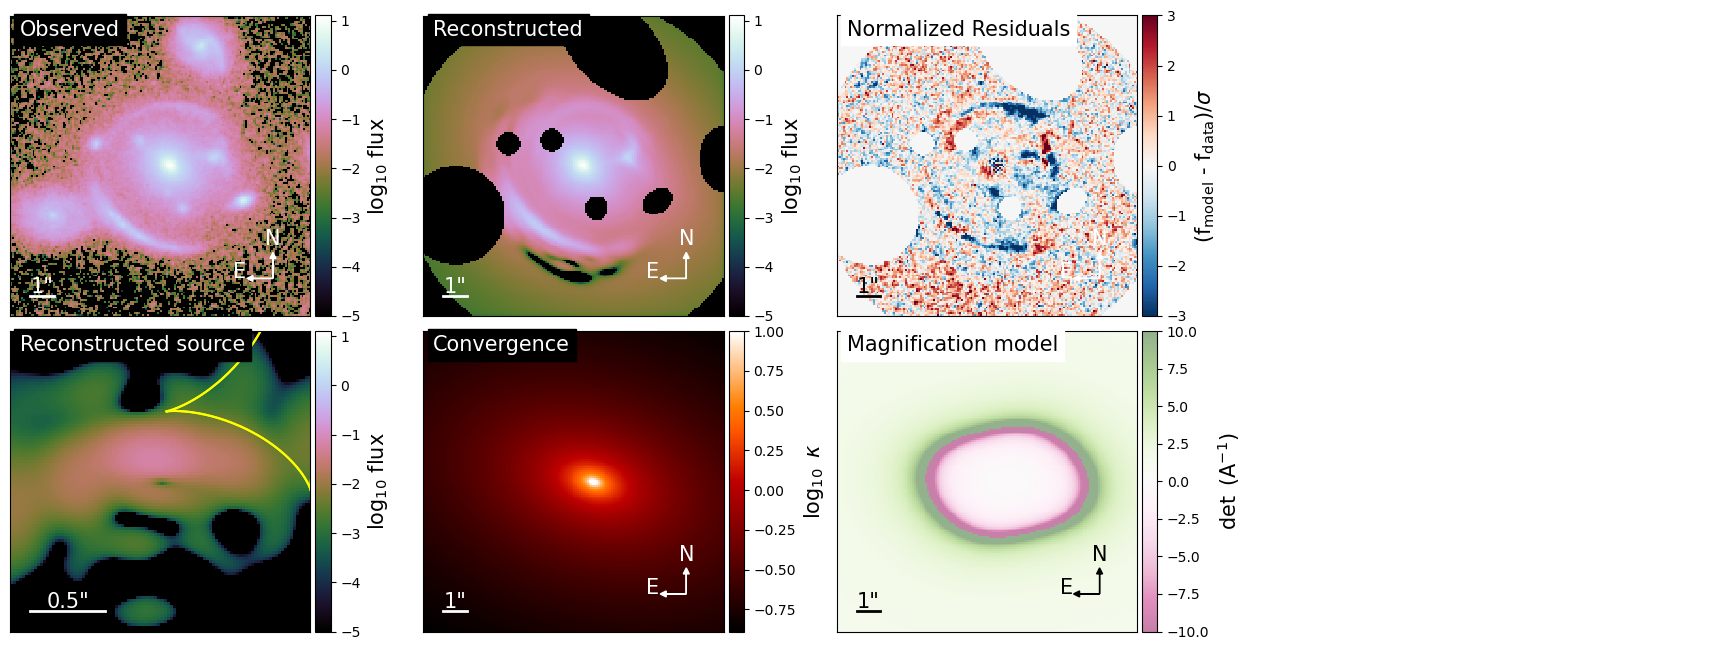

In [15]:
modelPlot = ModelPlot(
    multi_band_list_out,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood['image_likelihood_mask_list']
)


f, axes = plt.subplots(
    2, 3, figsize=(16, 8), sharex=False, sharey=False
)

modelPlot.data_plot(ax=axes[0, 0])
modelPlot.model_plot(ax=axes[0, 1])
modelPlot.normalized_residual_plot(
    ax=axes[0, 2], v_min=-3, v_max=3, cmap='RdBu_r'
)
modelPlot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.02, numPix=100, 
    with_caustics=True, scale_size=0.5
)
modelPlot.convergence_plot(
    ax=axes[1, 1], v_max=1, cmap='gist_heat'
)
modelPlot.magnification_plot(
    ax=axes[1, 2], cmap='PiYG'
)
f.tight_layout()
f.subplots_adjust(
    left=None, bottom=None, right=None,
    top=None, wspace=0., hspace=0.05
)
plt.show()


/opt/conda/envs/bdlensing/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:506: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(model), origin='lower', vmin=v_min, vmax=v_max,


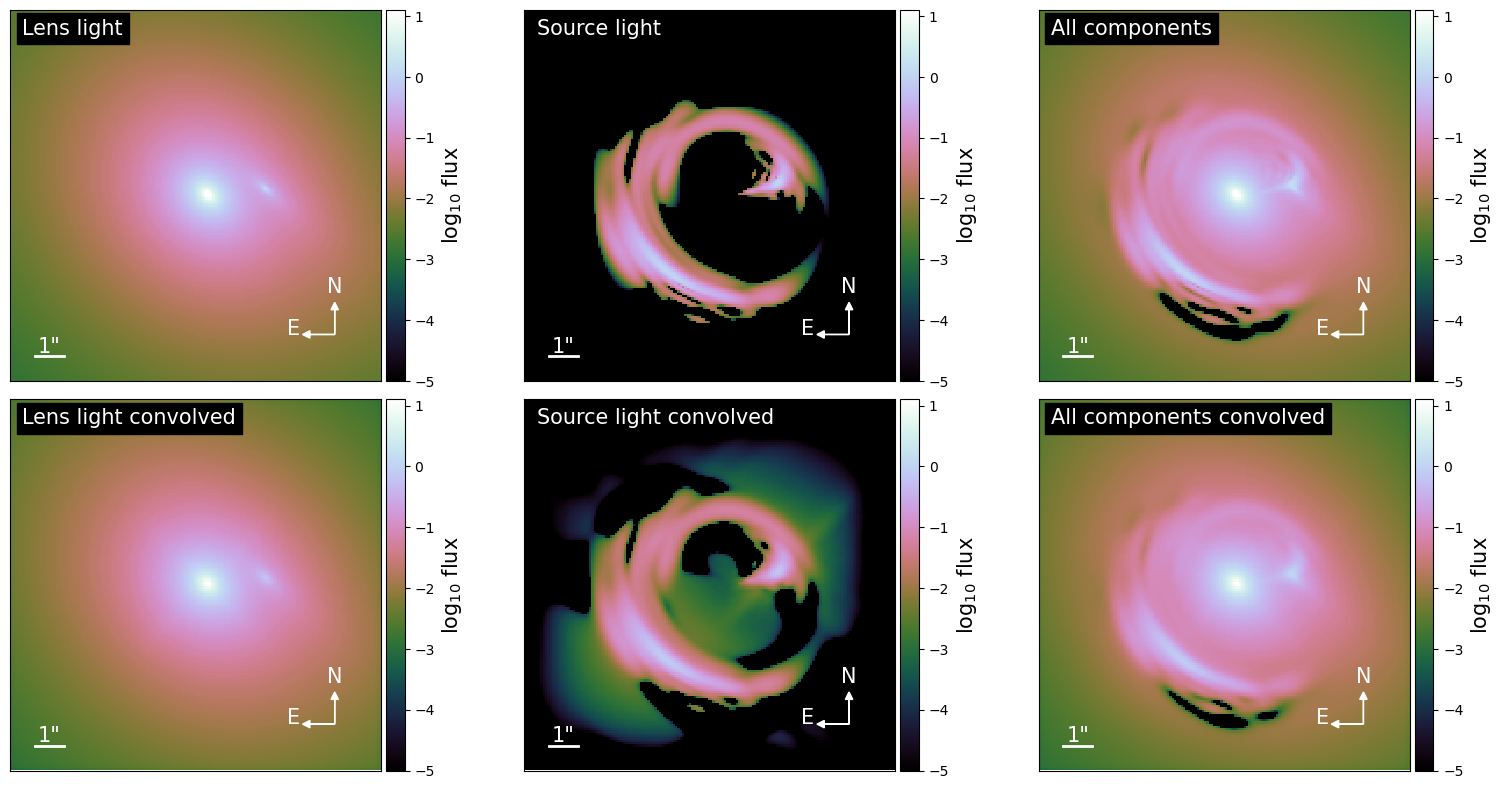

In [16]:
f, axes = plt.subplots(
    2, 3, figsize=(16, 8), sharex=False, sharey=False
)

modelPlot.decomposition_plot(
    ax=axes[0, 0], text='Lens light', lens_light_add=True, unconvolved=True
)
modelPlot.decomposition_plot(
    ax=axes[1, 0], text='Lens light convolved', lens_light_add=True
)
modelPlot.decomposition_plot(
    ax=axes[0, 1], text='Source light', source_add=True, unconvolved=True
)
modelPlot.decomposition_plot(
    ax=axes[1, 1], text='Source light convolved', source_add=True
)
modelPlot.decomposition_plot(
    ax=axes[0, 2], text='All components', source_add=True,
    lens_light_add=True, unconvolved=True
)
modelPlot.decomposition_plot(
    ax=axes[1, 2], text='All components convolved',
    source_add=True, lens_light_add=True, point_source_add=True
)
f.tight_layout()
f.subplots_adjust(
    left=None, bottom=None, right=None,
    top=None, wspace=0., hspace=0.05
)
plt.show()


In [18]:
print(output_[0])

{'kwargs_lens': [{'theta_E': 2.834668780099495, 'gamma': 2.0, 'e1': 0.19281975769686524, 'e2': 0.11830261564203058, 'center_x': -0.7683158119980547, 'center_y': -0.09617181937305545}, {'gamma1': -0.002741499867001062, 'gamma2': 0.1330052428560572, 'ra_0': 0.0, 'dec_0': 0.0}], 'kwargs_source': [{'amp': 1, 'R_sersic': 0.3034009890599944, 'n_sersic': 1.0, 'e1': 0.4999933168662967, 'e2': 0.05453099025113474, 'center_x': 0.13560705074367407, 'center_y': -0.6666237020934106}, {'amp': 1, 'n_max': 10, 'beta': 0.28801535085469, 'center_x': 0.13560705074367407, 'center_y': -0.6666237020934106}], 'kwargs_lens_light': [{'amp': 1, 'R_sersic': 0.18021322893884126, 'n_sersic': 1.0, 'e1': 0.004985939639252161, 'e2': 0.24523506937073872, 'center_x': -0.3259630911226335, 'center_y': -0.06488585191631097}, {'amp': 1, 'R_sersic': 1.2358321562108086, 'n_sersic': 4.0, 'e1': 0.011144744589140214, 'e2': 0.09136405208307348, 'center_x': -0.3259630911226335, 'center_y': -0.06488585191631097}, {'amp': 1, 'R_sers